# Dauphine PSL - Master IASD app

# Validation and Interpretability (partie 1)

- Lab duration: 1.30h

- Goals
  - understanding the importance of choosing the rights metrics for evaluation
  - implementing GradCAM for visual model interpretation

- Tools
  - `tensorboard` ([documentation](https://www.tensorflow.org/tensorboard?hl=fr)) -> monitoring training
  - `torchmetrics` ([documentation](https://torchmetrics.readthedocs.io/en/stable/)) -> model evaluation

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix

device = torch.device("cuda") if torch.cuda.is_available else "cpu"
device

device(type='cuda')

## Download dataset

In this part, we will use an imbalances version of the CIFAR dataset that is called `CIFAR10-LT`, for CIFAR-10 long tail. </br>
This dataset is imbalanced, it means that all the classes are not equally represented within the training set. </br>
Run the next cell for cloning the CIFAR10-LT associated github repository.

In [2]:
import sys

!git clone https://github.com/dvlab-research/MiSLAS.git

sys.path.append('./MiSLAS')

Cloning into 'MiSLAS'...
remote: Enumerating objects: 105, done.
remote: Counting objects: 100% (38/38), done.
remote: Compressing objects: 100% (17/17), done.
remote: Total 105 (delta 25), reused 21 (delta 21), pack-reused 67
Receiving objects: 100% (105/105), 14.58 MiB | 8.09 MiB/s, done.
Resolving deltas: 100% (38/38), done.


Once the repository is cloned, we can import a `CIFAR10_LT` object and from this object, we create:
- `train_loader`: training loader associated to imbalanced version of CIFAR-10
- `validation_loader`: classic loader of the CIFAR-10 dataset (balanced)
- `classes`: a list with the class names

In [3]:
from datasets.cifar10 import CIFAR10_LT


cifar_lt = CIFAR10_LT(distributed=False)

classes = cifar_lt.train_balance.dataset.classes

train_loader = cifar_lt.train_instance
validation_loader = cifar_lt.eval

100%|██████████| 170498071/170498071 [00:01<00:00, 98176644.63it/s] 


Extracting ./data/cifar10/cifar-10-python.tar.gz to ./data/cifar10
Files already downloaded and verified


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 40 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
len(cifar_lt.train_instance.dataset)

12406

The following cell displays how the CIFAR-10 dataset is balanced

In [ ]:
for class_, num_ in zip(classes,cifar_lt.cls_num_list):
  print(f"Class: {class_} contains {num_} samples")

plt.figure(figsize=(10,5))
plt.bar(classes, cifar_lt.cls_num_list)
plt.show()

Hence, you can see how much the dataset is imbalanced

### Training a model on an imbalance dataset

🛠 **EXERCICE :** Using transfer learning, import a `resnet18` pretrained model and train it for a classification task on the CIFAR10-LT dataset, using exactly the same asumpty than in lab2.

💡 Hint
- use the pre-training weights as an initialization
- use the `train` and `validate` function used in the previous lab session
- train the model on 5 epochs
- using a SGD `optimizer`
- and a `CrossEntropyLoss` criterion
- Do not forget to monitor you accuracy and losses using `TensorBoard`


In [4]:
import torch.optim as optim

def train(model, loader, epoch, optimizer, log_interval=200, writer=None):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for batch_idx, (images, labels) in enumerate(loader):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        if batch_idx % log_interval == 0:
            print(f"Train Epoch: {epoch} [{batch_idx * len(images)}/{len(loader.dataset)} "
                  f"({100. * batch_idx / len(loader):.0f}%)]\tLoss: {loss.item():.6f}")
    epoch_loss = running_loss / len(loader)
    epoch_accuracy = 100 * correct / total
    return epoch_loss

@torch.no_grad()
def validate(model, loader, loss_vector, accuracy_vector, step="Validation", writer=None):
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        val_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    val_loss /= len(loader)
    print(f'{step} loss: {val_loss:.6f}, Accuracy: {accuracy:.2f}%')
    if writer:
        writer.add_scalar(f'{step} loss', val_loss)
        writer.add_scalar(f'{step} accuracy', accuracy)
    loss_vector.append(val_loss)
    accuracy_vector.append(accuracy)
    return val_loss, accuracy


In [32]:
from torchvision.models import resnet18

num_classes = len(classes)

model = resnet18(pretrained=True)

num_features = model.fc.in_features

model.fc = nn.Sequential(
        nn.Linear(num_features, 256),
        nn.ReLU(),
        nn.Dropout(0.4),
        nn.Linear(256, num_classes)
)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [6]:
%load_ext tensorboard

In [ ]:
%tensorboard --logdir runs

In [ ]:
%%time
import torch
from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter("runs/cifat-lt-acc")

optimizer = optim.SGD(model.parameters(), lr=0.05, momentum=0.9)
epochs = 5

model = model.to(device)

criterion = nn.CrossEntropyLoss()

loss_training, acc_training = [], []
loss_validation, acc_validation = [], []

for epoch in range(1, epochs + 1):
    train(model,train_loader, epoch, optimizer, writer=writer)

    validate(model, train_loader, loss_training, acc_training, "Training", writer=writer)
    validate(model, validation_loader, loss_validation, acc_validation, "Validation", writer=writer)


Once the training is done, you can see that the model does not perform well
- Accuracy is increasing for training set
- Much faster than for the validation set

### Evaluation

From now, we have only monitored the accuracy of the model while training it. </br>
Let's now have a look at the **confusion matrix** for both the **training set** and the **validation set**.



#### Training set

🛠 **EXERCICE :** Compute the predictions of the model on the training set.
💡 Hint
- you will have to loop over the training loader
- use the `softmax` function to get the probability from the logits
- get the argmax from the probabilities
- stack the predictions in a list
- at the end of the loop, you can use [`torch.cat`](https://pytorch.org/docs/stable/generated/torch.cat.html) to flatten the resulting list

In [ ]:
#YOUR ANSWER HERE
def predictions(model, loader):
    predictions = []
    model.eval()
    with torch.no_grad():
        for images, _ in loader:
            images = images.to(device)
            outputs = model(images)
            probabilities = F.softmax(outputs, dim=1)
            _, preds = torch.max(probabilities, 1)
            predictions.append(preds.cpu())

    predictions = torch.cat(predictions, dim=0)
    return predictions

train_predictions = predictions(model, train_loader)

Now you computed the predictions, you can compute the confusion matrix of the predictions of your model on the training set.

🛠 **EXERCICE :** Compute the confusion matrix of your model's predictions on the training set and load the results in a pandas `DataFrame`.
💡 Hint
- you can use the [`confusion_matrix`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html) function in sklearn
- use the `classes` list for readibility

In [ ]:
#YOUR ANSWER HERE
from sklearn.metrics import confusion_matrix
import pandas as pd

train_labels = []
for _, labels in train_loader:
    train_labels.extend(labels.tolist())

train_labels = torch.tensor(train_labels)

cm_train = confusion_matrix(train_labels, train_predictions.numpy())

# to df
cm_train_df = pd.DataFrame(cm_train, index=classes, columns=classes)


Run the following cell for plotting the results

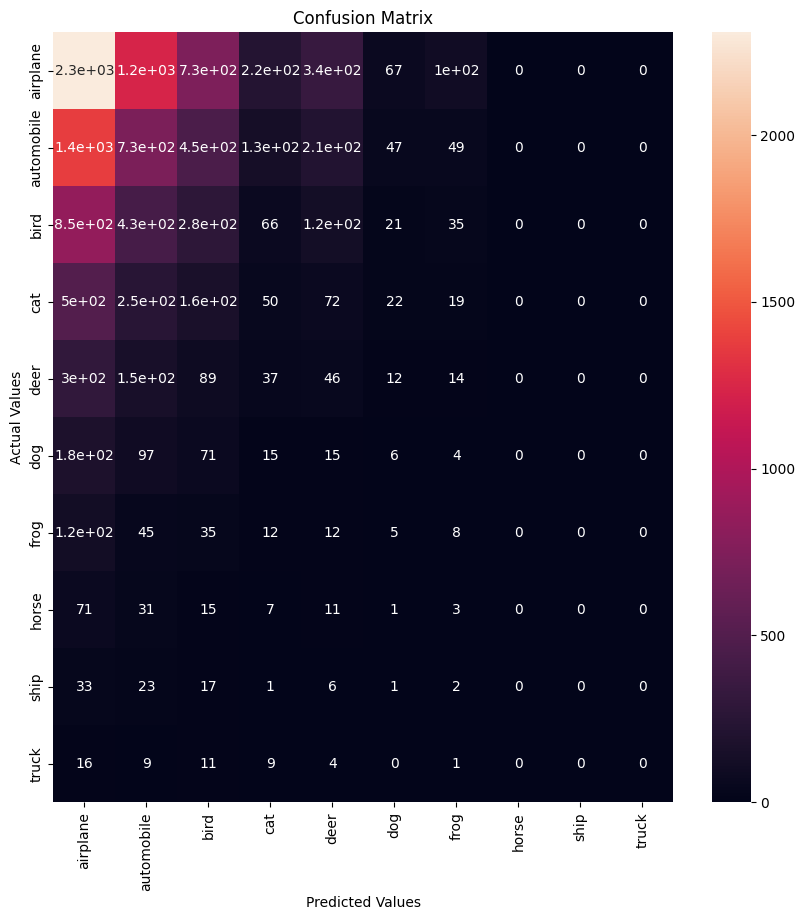

In [ ]:
#Plotting the confusion matrix
plt.figure(figsize=(10,10))
sns.heatmap(cm_train_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

In [ ]:
#YOUR ANSWER HERE

❓What are your interpretations?

```python
#YOUR ANSWER HERE
```
I would say that due to the uneven distribution of classes in the dataset, the model tends to predict either airplane or automobile (crowdest classes) for each instance, without attempting to predict the true class


#### Validation set (do the same on the validation set)

🛠 **EXERCICE :** Compute the predictions of the model on the validation set. \
💡 Hint
- you will have to loop over the validation loader
- use the `softmax` function to get the probability from the logits
- get the argmax from the probabilities
- stack the predictions in a list
- at the end of the loop, you can use [`torch.cat`](https://pytorch.org/docs/stable/generated/torch.cat.html) to flatten the resulting list

Now you computed the predictions, you can compute the confusion matrix of the predictions of your model on the training set.

🛠 **EXERCICE :** Compute the confusion matrix of your model's predictions on the validation set and load the results in a pandas `DataFrame`.
💡 Hint
- you can use the [`confusion_matrix`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html) function in sklearn
- use the `classes` list for readibility

In [ ]:
#YOUR ANSWER HERE
val_predictions = predictions(model, validation_loader)
validation_labels = []
for _, labels in validation_loader:
    validation_labels.extend(labels.tolist())

validation_labels = torch.tensor(validation_labels)

cm_val = confusion_matrix(validation_labels, val_predictions.numpy())

# to df
cm_val_df = pd.DataFrame(cm_val, index=classes, columns=classes)


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 40 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


❓Can you confirm your hypothesis?

```python
#YOUR ANSWER HERE
```
The same here, I would say that due to the uneven distribution of classes in the dataset, the model tends to predict either airplane or automobile (crowdest classes) for each instance, without attempting to predict the true class. It's even worst, when almost every prediction tend to be airplane


In [ ]:
#YOUR ANSWER HERE

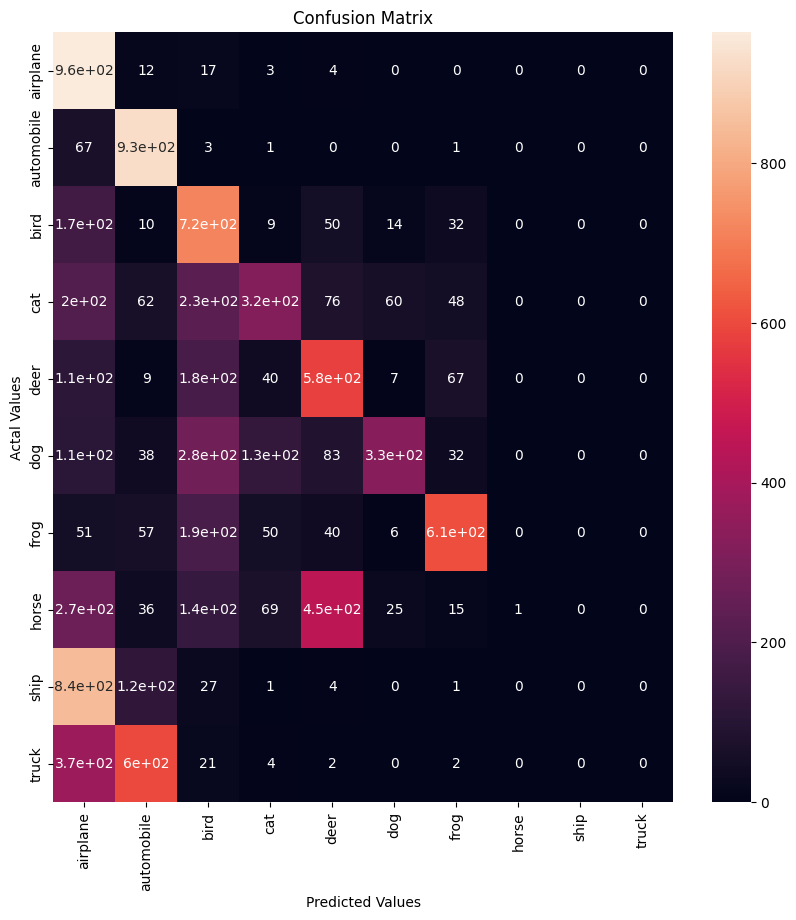

In [ ]:

plt.figure(figsize=(10,10))
sns.heatmap(cm_val_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

The results are even worse on the validation set
- the model is not capable of generelizing
- now you understand the importance of choosing the right metrics to evaluate and validate a model

### Monitoring the training using the right metrics

In this section, we will use the `torchmetrics` library to compute the several metric in order to monitor the training. </br>

Run the following cell to install the `torchmetrics` package.

In [9]:
!pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 841.5/841.5 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━

The objective of this section is to monitor the training with several metrics using the `torchmetrics` package. </br>

We will use the following metrics
- accuracy : torchmetrics.classification.MulticlassAccuracy
- precision : torchmetrics.classification.MulticlassPrecision
- recall : torchmetrics.classification.MulticlassRecall
- F1-score : torchmetrics.classification.MulticlassF1Score

Do not hesitate to use the [torchmetrics documentation](https://torchmetrics.readthedocs.io/en/latest/) in this part.

Here is an example from the documentation of how it works



In [ ]:
import torch
# import our library
import torchmetrics

# initialize metric
metric = torchmetrics.Accuracy(task="multiclass", num_classes=5)

n_batches = 10
for i in range(n_batches):
    # simulate a classification problem
    preds = torch.randn(10, 5).softmax(dim=-1)
    target = torch.randint(5, (10,))
    # metric on current batch
    acc = metric(preds, target)
    print(f"Accuracy on batch {i}: {acc}")

# metric on all batches using custom accumulation
acc = metric.compute()
print(f"Accuracy on all data: {acc}")

# Reseting internal state such that metric ready for new data
metric.reset()

Accuracy on batch 0: 0.10000000149011612
Accuracy on batch 1: 0.0
Accuracy on batch 2: 0.0
Accuracy on batch 3: 0.10000000149011612
Accuracy on batch 4: 0.10000000149011612
Accuracy on batch 5: 0.30000001192092896
Accuracy on batch 6: 0.30000001192092896
Accuracy on batch 7: 0.20000000298023224
Accuracy on batch 8: 0.10000000149011612
Accuracy on batch 9: 0.20000000298023224
Accuracy on all data: 0.14000000059604645


You can see that the metric object `accumulate` the values over the batches and `compute` the average at the end of the loop. </br>
⚠️ it is very important not to forget the `.reset()` in order to reset the accumulation process.

Moreover, you can use a `MetricCollection` object to store all of your metrics in a same object.
Here is an example from the [official documentation](https://torchmetrics.readthedocs.io/en/stable/pages/overview.html#metriccollection) :

In [ ]:
from torchmetrics import MetricCollection
from torchmetrics.classification import MulticlassAccuracy, MulticlassPrecision, MulticlassRecall
target = torch.tensor([0, 2, 0, 2, 0, 1, 0, 2])
preds = torch.tensor([2, 1, 2, 0, 1, 2, 2, 2])
metric_collection = MetricCollection([
    MulticlassAccuracy(num_classes=3, average="micro"),
    MulticlassPrecision(num_classes=3, average="macro"),
    MulticlassRecall(num_classes=3, average="macro")
])
print(metric_collection(preds, target))

{'MulticlassAccuracy': tensor(0.1250), 'MulticlassPrecision': tensor(0.0667), 'MulticlassRecall': tensor(0.1111)}


🛠 **EXERCICE :** Using a `MetricCollection` object from `torchmetrics`, change the code of the `validate` function in order to monitor the evaluation using the following metrics
- accuracy
- recall
- precision
- F1-Score

Log you metrics in `TensorBoard`

and train your model

In [20]:
#YOUR ANSWER HERE
from torchmetrics import MetricCollection
from torchmetrics.classification import MulticlassAccuracy, MulticlassPrecision, MulticlassRecall, MulticlassF1Score

@torch.no_grad()
def validate(model, loader, loss_vector, accuracy_vector, step="Validation", writer=None):
    model.eval()
    val_loss = 0.0

    metrics = MetricCollection({
        'accuracy': MulticlassAccuracy(num_classes=10, average="micro").to(device),
        'precision': MulticlassPrecision(num_classes=10, average="macro").to(device),
        'recall': MulticlassRecall(num_classes=10, average="macro").to(device),
        'f1': MulticlassF1Score(num_classes=10, average="macro").to(device)
    })

    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        val_loss += loss.item()

        metrics.update(outputs, labels)

    accuracy = metrics['accuracy'].compute()
    recall = metrics['recall'].compute()
    precision = metrics['precision'].compute()
    f1_score = metrics['f1'].compute()

    val_loss /= len(loader)
    print(f'{step} loss: {val_loss:.6f}, Accuracy: {accuracy:.2f}%, Precision: {precision:.2f}, Recall: {recall:.2f}, F1-Score: {f1_score:.2f}')

    if writer:
        writer.add_scalar(f'{step} loss', val_loss)
        writer.add_scalar(f'{step} accuracy', accuracy)
        writer.add_scalar(f'{step} precision', precision)
        writer.add_scalar(f'{step} recall', recall)
        writer.add_scalar(f'{step} F1-score', f1_score)

    loss_vector.append(val_loss)
    accuracy_vector.append(accuracy)
    return val_loss, accuracy


In [ ]:
%load_ext tensorboard

In [ ]:
%tensorboard --logdir runs

In [23]:
#YOUR ANSWER HERE
writer = SummaryWriter("runs/cifat-lt-torchmatrics")

optimizer = optim.SGD(model.parameters(), lr=0.05, momentum=0.9)
epochs = 5

model = model.to(device)

criterion = nn.CrossEntropyLoss()

loss_training, acc_training = [], []
loss_validation, acc_validation = [], []

for epoch in range(1, epochs + 1):
    train(model,train_loader, epoch, optimizer, writer=writer)

    validate(model, train_loader, loss_training, acc_training, "Training", writer=writer)
    validate(model, validation_loader, loss_validation, acc_validation, "Validation", writer=writer)

Train Epoch: 1 [0/12406 (0%)]	Loss: 0.478922
Training loss: 0.567860, Accuracy: 0.81%, Precision: 0.51, Recall: 0.46, F1-Score: 0.46
Validation loss: 1.888922, Accuracy: 0.45%, Precision: 0.49, Recall: 0.45, F1-Score: 0.37
Train Epoch: 2 [0/12406 (0%)]	Loss: 0.426537
Training loss: 0.510686, Accuracy: 0.83%, Precision: 0.59, Recall: 0.47, F1-Score: 0.49
Validation loss: 2.169064, Accuracy: 0.46%, Precision: 0.48, Recall: 0.46, F1-Score: 0.39
Train Epoch: 3 [0/12406 (0%)]	Loss: 0.530558
Training loss: 0.468460, Accuracy: 0.85%, Precision: 0.60, Recall: 0.52, F1-Score: 0.54
Validation loss: 1.714152, Accuracy: 0.51%, Precision: 0.49, Recall: 0.51, F1-Score: 0.46
Train Epoch: 4 [0/12406 (0%)]	Loss: 0.402977
Training loss: 0.519210, Accuracy: 0.83%, Precision: 0.56, Recall: 0.54, F1-Score: 0.54
Validation loss: 1.804638, Accuracy: 0.52%, Precision: 0.47, Recall: 0.52, F1-Score: 0.45
Train Epoch: 5 [0/12406 (0%)]	Loss: 0.348882
Training loss: 0.466567, Accuracy: 0.85%, Precision: 0.61, Reca

Now you can properly monitor the training of your model using the appropriate metrics.
You can see that the overall accuracy is good on your training set.

### Training a CNN for classification on an imbalanced dataset

By now you should figure out that your classification model is not good enough on misrepresented classes.

To address the issue of imbalanced datasets, several strategies can be adopted. These strategies aim to minimize the impact of class imbalance on the model's performance. The following strategies can be adopted :

- **Class Weighting**: Adjust the weights for different classes to compensate for the imbalance. This can be done by assigning a higher weight to the underrepresented classes.

- **Undersampling and Oversampling**:
  - Undersampling: Reduce the number of examples in the overrepresented classes to match the number of examples in the underrepresented classes.
  - Oversampling: Increase the number of examples in the underrepresented classes by replicating them until they are balanced with the overrepresented classes. A popular technique is SMOTE (Synthetic Minority Over-sampling Technique), although it's more commonly used with traditional machine learning algorithms.
- **Data Augmentation**: Generate new training data by applying transformations (such as rotation, shift, zoom, etc.) to the images of the underrepresented class. This can help increase the number of training examples for the underrepresented classes without collecting new data.



---


In this section, you will be asked to train a CNN using both a class weighting strategy and data augementation to obtain better performance.


PyTorch allows doing this easily by using the weight parameter of some loss criteria, like torch.nn.CrossEntropyLoss.

🛠 **EXERCICE :** Using the same previous CNN architecture, modify your training in order to adopt a class weighting strategy. Also, try several data augmentation strategies and

💡 **Hint :**
- See pytorch documentation of [torch.nn.CrossEntropyLoss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html)
- See scikit-learn documentation for computing class weights [compute_class_weight](https://scikit-learn.org/stable/modules/generated/sklearn.utils.class_weight.compute_class_weight.html)



In [33]:
#YOUR ANSWER HERE
# Class Weighting
from sklearn.utils.class_weight import compute_class_weight

writer = SummaryWriter("runs/cifat-lt-cw")


class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(classes), y=classes)
class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)


criterion = nn.CrossEntropyLoss(weight=class_weights)

optimizer = optim.SGD(model.parameters(), lr=0.05, momentum=0.9)
epochs = 5

model = model.to(device)

loss_training, acc_training = [], []
loss_validation, acc_validation = [], []

for epoch in range(1, epochs + 1):
    train(model,train_loader, epoch, optimizer, writer=writer)

    validate(model, train_loader, loss_training, acc_training, "Training", writer=writer)
    validate(model, validation_loader, loss_validation, acc_validation, "Validation", writer=writer)


Files already downloaded and verified
Files already downloaded and verified


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 40 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train Epoch: 1 [0/12406 (0%)]	Loss: 2.410413
Training loss: 0.821395, Accuracy: 0.74%, Precision: 0.32, Recall: 0.36, F1-Score: 0.33
Validation loss: 2.664986, Accuracy: 0.35%, Precision: 0.18, Recall: 0.35, F1-Score: 0.24
Train Epoch: 2 [0/12406 (0%)]	Loss: 0.904690
Training loss: 0.765206, Accuracy: 0.76%, Precision: 0.43, Recall: 0.37, F1-Score: 0.37
Validation loss: 2.213610, Accuracy: 0.38%, Precision: 0.35, Recall: 0.38, F1-Score: 0.27
Train Epoch: 3 [0/12406 (0%)]	Loss: 0.737955
Training loss: 0.680541, Accuracy: 0.78%, Precision: 0.48, Recall: 0.41, F1-Score: 0.41
Validation loss: 2.322076, Accuracy: 0.41%, Precision: 0.37, Recall: 0.41, F1-Score: 0.33
Train Epoch: 4 [0/12406 (0%)]	Loss: 0.751007
Training loss: 0.663113, Accuracy: 0.79%, Precision: 0.48, Recall: 0.45, F1-Score: 0.44
Validation loss: 1.851218, Accuracy: 0.45%, Precision: 0.37, Recall: 0.45, F1-Score: 0.36
Train Epoch: 5 [0/12406 (0%)]	Loss: 0.558914
Training loss: 0.544898, Accuracy: 0.82%, Precision: 0.52, Reca